# Feature Selection with K-means experiment (dataset2 - transaction data)

Four approaches of feature selection:
1. Variable Ranking 
2. Correlation Heatmap 
3. PCA
4. ICA

Two clusters in K-means clustering: 
<br>Fraud(1) and Non-fraud(0)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# 
df = pd.read_csv("dataset/optical_care_transaction_opticiens.csv", sep = ';')
df.shape

(12616, 27)

In [3]:
# target dataset
target = pd.read_csv('dataset/almerys_fraudulent_optician_id.csv')
target.shape

(292, 1)

In [4]:
num_cols = df.columns[1:]
num_cols

Index(['nb_lignes_PEC', 'dep_identique', 'dep_limit', 'dep_non_limit',
       'PEC_CRE', 'PEC_ANN', 'PEC_ACC', 'PEC_FAC', 'PEC_REF',
       'taux_non_ventes', 'Prix_monture', 'Prix_verres', 'Prix_equipement',
       'Pourcent_remise_verre', 'Pourcent_remise_monture',
       'Pourcent_remise_total', 'cor_sphere_VD', 'cor_cylindre_VD',
       'cor_addition_VD', 'cor_sphere_VG', 'cor_cylindre_VG',
       'cor_addition_VG', 'facteur_correction', 'age_moyen',
       'nb_prescripteurs', 'nb_PEC_par_prescripteurs'],
      dtype='object')

In [5]:
df['fraud'] = [1 if x in target['ref_PS'].tolist() else 0 for x in df['ref_PS'].tolist()]
df.head()

,ref_PS,nb_lignes_PEC,dep_identique,dep_limit,dep_non_limit,PEC_CRE,PEC_ANN,PEC_ACC,PEC_FAC,PEC_REF,...,cor_cylindre_VD,cor_addition_VD,cor_sphere_VG,cor_cylindre_VG,cor_addition_VG,facteur_correction,age_moyen,nb_prescripteurs,nb_PEC_par_prescripteurs,fraud
0,8c47fdd7c69650b,53,96.23,1.89,1.89,30.19,3.77,0.00,62.26,3.77,...,0.056604,0.226415,-0.301887,0.056604,0.226415,1.056604,45.396226,24,2.21,0
1,89bf4429f3ebda1,31,100.00,0.00,0.00,19.35,22.58,0.00,51.61,6.45,...,0.000000,0.129032,0.000000,0.096774,0.193548,0.548387,49.096774,11,2.82,0
2,5076215e2ee1797,22,95.45,4.55,0.00,4.55,13.64,13.64,68.18,0.00,...,0.318182,0.181818,-0.272727,0.227273,0.181818,2.318182,34.863636,11,2.00,0
3,3a771e3f5cbc3b2,41,97.56,0.00,2.44,12.20,0.00,4.88,82.93,0.00,...,0.000000,0.048780,0.000000,0.000000,0.048780,0.365854,31.829268,8,5.12,1
4,ced6f62ac55fd34,4,50.00,0.00,50.00,0.00,25.00,0.00,75.00,0.00,...,0.000000,0.000000,-0.500000,0.000000,0.000000,1.000000,43.750000,3,1.33,0


## Method1 - Variable Ranking

SelectKBest is a feature selection method in scikit-learn library, which selects the top k features with the highest scores based on a given score function. 

The selected features can then be used to train a classification model, potentially leading to better performance and faster training times compared to using all the features.

In [31]:
df_ = pd.read_csv('dataset/normalized.csv')
df_.rename(columns={'Prix_monture_x' : 'Prix_monture', 'Prix_verres_x':'Prix_verres'}, inplace=True)
df_['ref_PS'] = df['ref_PS']
df_['is_fraud'] = [1 if x in target['ref_PS'].tolist() else 0 for x in df_['ref_PS'].tolist()]

# Variables
X = df_[num_cols]
y = df_['is_fraud']

X_abs = np.abs(X) # convert negative vals to + (for classification, chi function only takes positive input values)

selector = SelectKBest(score_func=chi2, k=15) # select top 10 best features
fit = selector.fit(X_abs, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_abs.columns)

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # naming the dataframe columns
featureScores = featureScores.sort_values(by='Score', ascending=False)
featureScores[:15] # print top 15 features

# top_features = featureScores.head(15)


,Specs,Score
13,Pourcent_remise_verre,33.134720
14,Pourcent_remise_monture,25.672012
15,Pourcent_remise_total,24.388881
2,dep_limit,10.853283
3,dep_non_limit,7.551482
23,age_moyen,5.381550
10,Prix_monture,5.369020
1,dep_identique,4.648377
5,PEC_ANN,1.573067
6,PEC_ACC,1.317042


<Figure size 864x576 with 0 Axes>

<AxesSubplot:xlabel='Score', ylabel='Specs'>

Text(0.5, 1.0, 'Top 15 Feature Importances')

Text(0.5, 0, 'Importance Score')

Text(0, 0.5, 'Features')

Text(33.13472002319655, 0, '33.13')

Text(25.672012100496246, 1, '25.67')

Text(24.388881429986657, 2, '24.39')

Text(10.853282711283425, 3, '10.85')

Text(7.551481569227204, 4, '7.55')

Text(5.381549682084434, 5, '5.38')

Text(5.369020386275011, 6, '5.37')

Text(4.648376839947524, 7, '4.65')

Text(1.573067109986996, 8, '1.57')

Text(1.3170419580214938, 9, '1.32')

Text(1.0341745705795724, 10, '1.03')

Text(0.9642994745512583, 11, '0.96')

Text(0.7877768504378726, 12, '0.79')

Text(0.6203401142967555, 13, '0.62')

Text(0.4857584517931703, 14, '0.49')

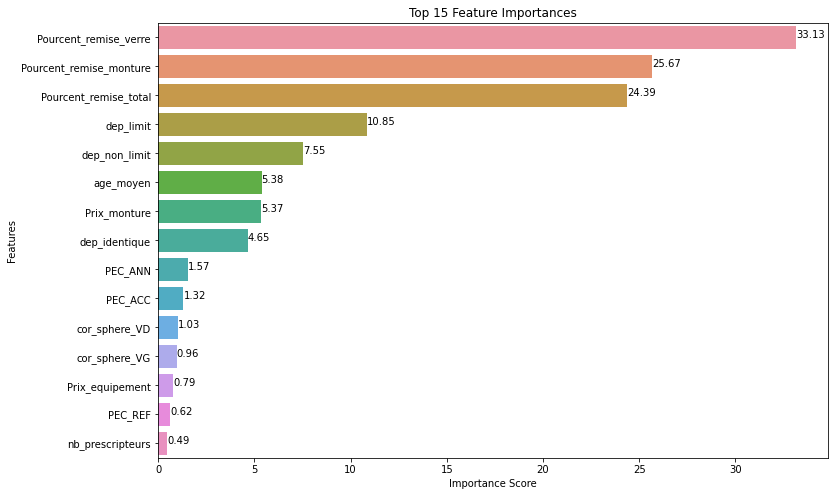

In [32]:
# Set up the figure and axis
plt.figure(figsize=(12, 8))

# Create a horizontal bar plot
sns.barplot(x='Score', y='Specs', data=featureScores.head(15), orient='h')

# Set plot title and labels
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')

for index, value in enumerate(featureScores[:15]['Score']):
    plt.text(value, index, f"{value:.2f}")  

# Display the plot
plt.savefig('plots/rank_feature.png', bbox_inches='tight')
plt.show()

Above result shows the top 15 features are: <br>
Pourcent_remise_verre, Pourcent_remise_monture, Pourcent_remise_total, dep_limit, dep_non_limit, age_moyen, Prix_monture, dep_identique, PEC_ANN, PEC_ACC, cor_sphere_VD, cor_sphere_VG, Prix_equipement, PEC_REF, nb_prescripteurs

---

## Method2 - Correlation Matrix with Heatmap

We can also do variable selection by correlation between features or between features and target variables. 

The lower the correlation between features -> the better. 

The higher the correlation between features and target -> the better.

<Figure size 1440x1440 with 0 Axes>

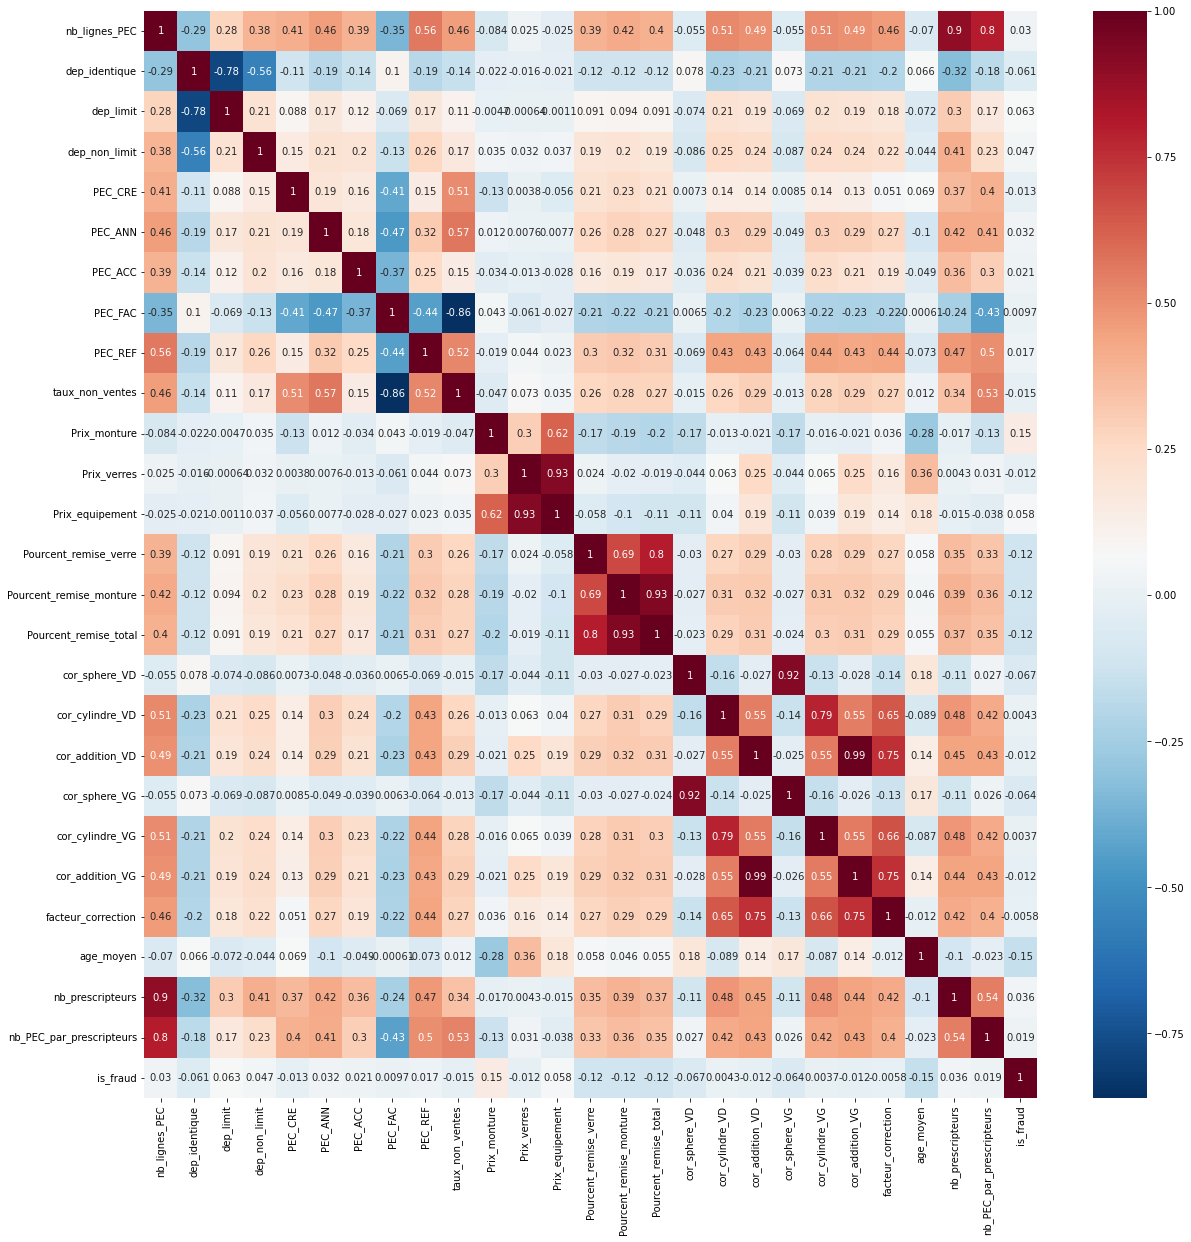

In [30]:
#get correlations of each features in dataset
corrmat = df_.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
#plot heat map
g=sns.heatmap(df_[top_corr_features].corr(), annot=True, cmap="RdBu_r")

# g=sns.heatmap(labeled_df[top_corr_features].corr(), annot=True, cmap="RdBu_r")
g.get_figure().savefig('plots/feature_selection_heatmap.png', bbox_inches='tight')

The larger the value, the higher the correlation, the deeper the color.

Multicollinearity: <br>
nb_lignes_PEC, Prix_verres, Pourcent_remise_verre, Pourcent_remise_monture, cor_sphere_VD, cor_cylindre_VD, cor_addition_VD

Pick up top features relate to 'fraud' manually: <br>
Prix_monture, dep_limit, Prix_equipement, dep_non_limit, nb_prescripteurs, PEC_ANN, nb_lignes_PEC, PEC_ACC, nb_PEC_par_prescripteurs, PEC_REF, age_moyen, Pourcent_remise_total, cor_sphere_VG, dep_identique

Top features are similar to Method1.

## Method3 - PCA for unsupervised ML

Principal Components Analysis

A dimension reduction technique that finds a new set of uncorrelated features (principal components) that capture the most variance in the data. The new features can be used for clustering, and the original features that have low weights in the principal components can be discarded. 

In [35]:
def my_pca(num):
    # Create a PCA object with n_components=2
    pca = PCA(n_components=num)
    X_pca = pca.fit_transform(X)

    # Create a KMeans object with n_clusters=2
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(X_pca)

    # Get the labels and centroids of the clusters
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Add the cluster labels to the original data
    df_pca_kmeans = df_.copy()
    df_pca_kmeans['cluster'] = labels

    if num == 2:
        plt.scatter(X_pca[:,0], X_pca[:,1], c=df_pca_kmeans['cluster'])
        plt.xlabel('pc1')
        plt.ylabel('pc2')
        plt.show()

    # Count the number of same values in columns 'fraud' and 'cluster'
    count = (df_pca_kmeans['is_fraud'] == df_pca_kmeans['cluster']).sum()

    # Accuracy of this clustering
    acc = count/len(df_pca_kmeans) 

    return acc

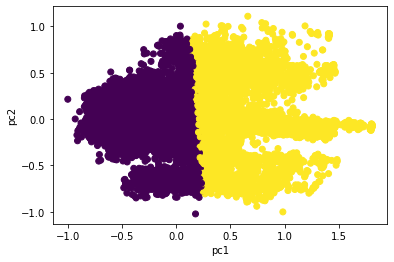

17

0.6872225745085606

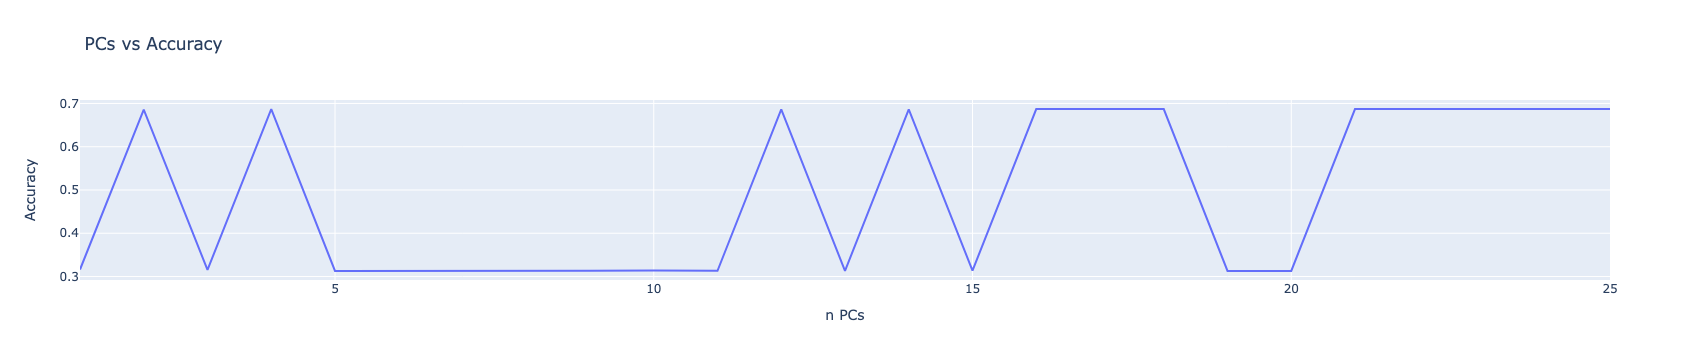

In [36]:
# Select the best num of PCs by PCA and then show the accuracy of K-means clustering

max_acc = 0
max_n = 0

acc = []
n = []

for i in range(1,len(num_cols)):
    res = my_pca(i)
    n.append(i)
    acc.append(res)
    if res > max_acc:
        max_acc = res
        max_n = i
    
max_n
max_acc


import plotly.graph_objs as go

trace = go.Scatter(x=n, y=acc, mode='lines', name='line chart')
layout = go.Layout(title='PCs vs Accuracy', xaxis=dict(title='n PCs'), yaxis=dict(title='Accuracy'))
fig = go.Figure(data=[trace], layout=layout)

fig.show()



Above result shows when using 17 PCs(Principal Components), the accuracy could reach 0.69 by K-means clustering.


---

## Method4 - ICA

Independent Component Analysis is another dimension reduction technique that tries to find a linear transformation of the input features that maximizes the independence between the resulting components. ICA can be used for feature selection in clustering by selecting only the independent components with high variance. 

In [37]:
def my_ica(num):

    # Select the top n independent components with high variance to use for clustering
    n_components = num
    top_components = sorted_indices[:n_components]

    # Use the selected independent components as features for clustering
    kmeans = KMeans(n_clusters=2, random_state=777)
    kmeans.fit(X_ica[:, top_components])

    # Get the labels and centroids of the clusters
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Add the cluster labels to the original data
    df_ica_kmeans = df_.copy()
    df_ica_kmeans['cluster'] = labels

    # Count the number of same values in columns 'fraud' and 'cluster'
    count = (df_ica_kmeans['is_fraud'] == df_ica_kmeans['cluster']).sum()

    # Accuracy of this clustering
    return count/len(df_ica_kmeans)


In [38]:
# Apply ICA to the dataset
ica = FastICA(random_state=42)
X_ica = ica.fit_transform(X)

# Calculate the variance of each independent component
variances = np.var(X_ica, axis=0)
var = pd.DataFrame(variances)
cols = pd.DataFrame(X.columns)

feature_var = pd.concat([cols, var], axis=1)

feature_var.columns = ['Feature','Variance']
feature_var = feature_var.sort_values(by='Variance', ascending=False)

variances
feature_var

# Sort the independent components by variance in descending order
sorted_indices = np.argsort(variances)[::-1]

array([7.92644261e-05, 7.92644261e-05, 7.92644261e-05, 7.92644261e-05,
       7.92644261e-05, 7.92644261e-05, 7.92644261e-05, 7.92644261e-05,
       7.92644261e-05, 7.92644261e-05, 7.92644261e-05, 7.92644261e-05,
       7.92644261e-05, 7.92644261e-05, 7.92644261e-05, 7.92644261e-05,
       7.92644261e-05, 7.92644261e-05, 7.92644261e-05, 7.92644261e-05,
       7.92644261e-05, 7.92644261e-05, 7.92644261e-05, 7.92644261e-05,
       7.92644261e-05, 7.92644261e-05])

,Feature,Variance
4,PEC_CRE,0.000079
2,dep_limit,0.000079
21,cor_addition_VG,0.000079
15,Pourcent_remise_total,0.000079
17,cor_cylindre_VD,0.000079
9,taux_non_ventes,0.000079
3,dep_non_limit,0.000079
25,nb_PEC_par_prescripteurs,0.000079
13,Pourcent_remise_verre,0.000079
1,dep_identique,0.000079


12

0.8484464172479391

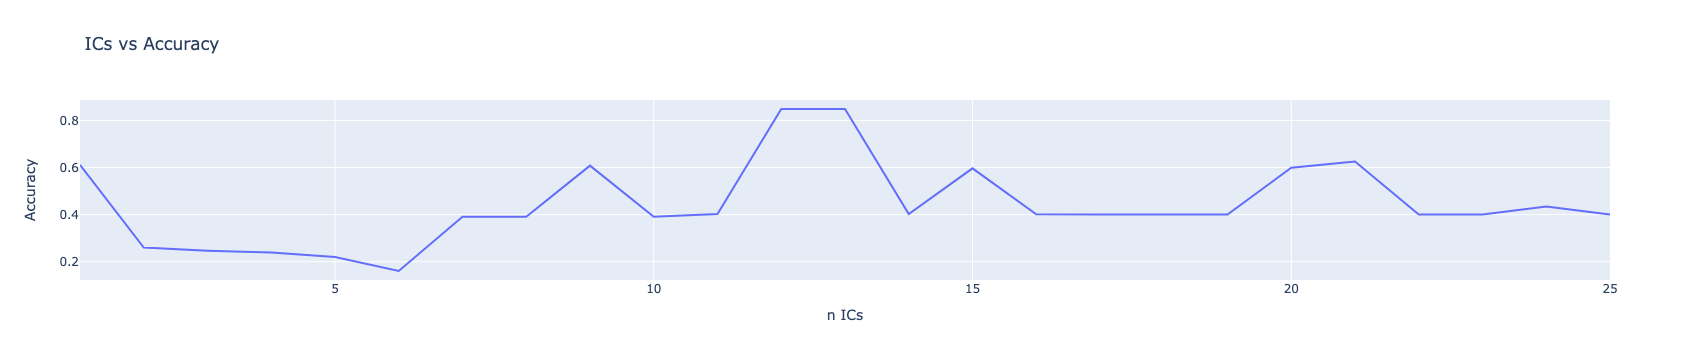

In [40]:
# Select the best num of PCs by ICA and then show the accuracy of K-means clustering
max_acc = 0
max_n = 0

acc = []
n = []

for i in range(1,len(num_cols)):
    res = my_ica(i)
    n.append(i)
    acc.append(res)
    if res > max_acc:
        max_acc = res
        max_n = i
    
max_n
max_acc


import plotly.graph_objs as go

trace = go.Scatter(x=n, y=acc, mode='lines', name='line chart')
layout = go.Layout(title='ICs vs Accuracy', xaxis=dict(title='n ICs'), yaxis=dict(title='Accuracy'))
fig = go.Figure(data=[trace], layout=layout)

fig.show()


Above result shows when using 12 ICs(Individual Components), the accuracy could reach 0.85 by K-means.

Due to ICA is a non-deterministic algorithm, which means that the algorithm may converge to different solutions each time it is applied to the same data. --> We set a random seed to 42 to obtain a stable result.


---

#### Summary
Ranking using SelectKBest()<br>
Pourcent_remise_verre, Pourcent_remise_monture, Pourcent_remise_total, dep_limit, dep_non_limit, age_moyen, Prix_monture, dep_identique, PEC_ANN, PEC_ACC, cor_sphere_VD, cor_sphere_VG, Prix_equipement, PEC_REF, nb_prescripteurs

Correlation Heatmap<br>
Prix_monture, dep_limit, Prix_equipement, dep_non_limit, nb_prescripteurs, PEC_ANN, nb_lignes_PEC, PEC_ACC, nb_PEC_par_prescripteurs, PEC_REF, age_moyen, Pourcent_remise_total, cor_sphere_VG, dep_identique


In [15]:
df = pd.read_csv("data/optical_care_transaction_opticiens.csv", sep = ';')
df.shape

FileNotFoundError: [Errno 2] No such file or directory: 'data/optical_care_transaction_opticiens.csv'

In [ ]:
df2 = pd.read_csv("data/historical_data.csv", sep = ';')
df2.shape

In [ ]:
df3 = pd.merge(df, df2, on='ref_PS', how='left')
df3.shape

In [ ]:
df3['ref_PS'].nunique()

In [ ]:
df3.drop_duplicates(subset=['ref_PS'])

In [ ]:
null_percentages = df3.isnull().mean()

# Get the column names with more than 80% null values
columns_to_drop = null_percentages[null_percentages > 0.8].index

# Drop columns with more than 80% null values
df4 = df3.drop(columns=columns_to_drop)
df4.drop_duplicates(inplace=True)
df4

In [ ]:
df4.to_csv('merged_data.csv', index=False)